# Classifying Actuarial Data with LLMs

By Paul Beard and Kay Khine Myo

## Introduction

Large Language Models (LLMs) are increasingly playing a role in actuarial work. One recent study by the SOA [https://www.soa.org/4ac5cf/globalassets/assets/files/resources/research-report/2025/2025-11-ait-172-ai-quarter-survey-report.pdf] found that actuaries are currently most likely to use LLMs for brainstorming, writing and interpreting documents, and code generation. In this article, we consider another potential use case, to save on the time-consuming task of data cleansing. 

Normally data cleansing can be carried out by code, manipulation or in some cases manually. Occassionally our dataset is just too messy, nuanced and large for any of these options to work well. We explore a case study with one such dataset. By building a pipeline within Python we cleanse the data via an LLM. We also explore some techniques beyond prompting with allow us to get the most out of our LLM.

## Initial Case Study

For this case study we have taken the ICD-10 causes of death as our dataset. There are thousands of causes of death in here, but we want to classify them into a small group of broader categories. The broader categories we have pulled from a paper online related to the cause-specific mortality impact of smoking [https://pmc.ncbi.nlm.nih.gov/articles/PMC3229033/]. To make our ICD-10 causes of death compatible with the hazard ratios in this paper, we wish to classify each of them into one of:

    "ischaemic heart disease"
    "cerebrovascular disease"
    "pulmonary disease"
    "lung cancer"
    "colorectal cancer"
    "larynx cancer"
    "kidney cancer"
    "acute myeloid leukemia"
    "oral cavity cancer"
    "esophageal cancer"
    "pancreatic cancer"
    "bladder cancer"
    "stomach cancer"
    "prostate cancer"
    "none"

To get a measure of the results, we also attempted this classification piece ourselves. We should caveate that our estimates are our own best guesses, and may be incorrect in places. After all, to err is human!

We got some initial results through from the OpenAI gpt-4o model. In general performance was quite strong, with an accuracy of [INSERT ACCURACY]. The performance is summarised below

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import great_tables as gt

# Human predictions
human_pred_csv = Path("./Data/cause_of_death.csv")
cod_df = pd.read_csv(human_pred_csv)
hm_df = cod_df[cod_df["train_test"] == "test"][[
    "cause_of_death", "category_human"]]


rec = hm_df

suffixes = ["mini_base", "base_0"]
for suffix in suffixes:
    filename = f"output_gpt_4o_{suffix}.csv"
    output_csv_path = Path(f"./Data/{filename}")
    cols_keep = ["cause_of_death", "category"]
    lp_df = pd.read_csv(output_csv_path).loc[:, cols_keep]
    rec = pd.merge(rec, lp_df, on="cause_of_death")
    rec[suffix] =  rec["category"].case_when(
        caselist= [
            (lambda x: (rec["category_human"] == x) & (x == "none"), "TN"),
            (lambda x: (rec["category_human"] == x) & (x != "none"), "TP"),
            (lambda x: (rec["category_human"] != x) & (x == "none"), "FN"),
            (lambda x: (rec["category_human"] != x) & (x != "none"), "FP")
            ]
    )
    rec = rec.drop("category", axis=1)
    

sdf = (rec[suffixes]
 .melt()
 .value_counts()
 .reset_index()
 .set_index("variable")
 .pivot(columns="value", values="count")
 .apply(lambda x: x.fillna(0))
)

sdf = sdf.assign(
    precision = sdf["TP"] / (sdf["TP"] + sdf["FP"]),
    recall = sdf["TP"] / (sdf["TP"] + sdf["FN"])
)
sdf = sdf.assign(
    f1 = 2 * sdf["precision"] * sdf["recall"] / (sdf["precision"] + sdf["recall"])
)

from great_tables import GT, style, loc, nanoplot_options

nnplt = nanoplot_options(
                data_point_radius=20,
                data_bar_fill_color="forestgreen",
                show_vertical_guides=False
            )

# 1. Initialize the table
tab = (
    GT(sdf.reset_index())
    
    # 2. Group columns under 'Count' and 'Scores' (Spanners)
    .tab_spanner(label="Count", columns=["TN", "FN", "TP", "FP"])
    .tab_spanner(label="Scores", columns=["precision", "recall", "f1"])
    .cols_label(
        variable="Bias",
        TN="True Negative", FN="False Negative",
        TP="True Positive", FP="False Positive",
        precision="Precision", recall="Recall", f1="F1"
    )
    .fmt_percent(columns=["precision", "recall", "f1"], decimals=0)
    .fmt_number(columns=["TN", "FN", "TP", "FP"], decimals=0)
    .fmt_nanoplot(columns="precision", plot_type="bar", autoscale=False, options=nnplt, expand_y=True)
    .fmt_nanoplot(columns="recall", plot_type="bar", autoscale=False, options=nnplt)
    .fmt_nanoplot(columns="f1", plot_type="bar", autoscale=False, options=nnplt)
    

    .cols_align(align="center", columns=["TN", "FN", "TP", "FP", "precision", "recall", "f1"])
)

tab

GT(_tbl_data=value   variable  FN  FP   TN  TP  precision    recall        f1
0         base_0  17   6  927  50   0.892857  0.746269  0.813008
1      mini_base  31   8  925  36   0.818182  0.537313  0.648649, _body=<great_tables._gt_data.Body object at 0x0000021664FCF1D0>, _boxhead=Boxhead([ColInfo(var='variable', type=<ColInfoTypeEnum.default: 1>, column_label='Bias', column_align='left', column_width=None), ColInfo(var='TN', type=<ColInfoTypeEnum.default: 1>, column_label='True Negative', column_align='center', column_width=None), ColInfo(var='FN', type=<ColInfoTypeEnum.default: 1>, column_label='False Negative', column_align='center', column_width=None), ColInfo(var='TP', type=<ColInfoTypeEnum.default: 1>, column_label='True Positive', column_align='center', column_width=None), ColInfo(var='FP', type=<ColInfoTypeEnum.default: 1>, column_label='False Positive', column_align='center', column_width=None), ColInfo(var='precision', type=<ColInfoTypeEnum.default: 1>, column_label='Precision', column_align='center', column_width=None), ColInfo(var='recall', type=<ColInfoTypeEnum.default: 1>, column_label='Recall', column_align='center', column_width=None), ColInfo(var='f1', type=<ColInfoTypeEnum.default: 1>, column_label='F1', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000021664C421E0>, _spanners=Spanners([SpannerInfo(spanner_id='Count', spanner_level=0, spanner_label='Count', spanner_units=None, spanner_pattern=None, vars=['TN', 'FN', 'TP', 'FP'], built=None), SpannerInfo(spanner_id='Scores', spanner_level=0, spanner_label='Scores', spanner_units=None, spanner_pattern=None, vars=['precision', 'recall', 'f1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000021664B87650>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000021664B848F0>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000021664B87350>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000021664B850D0>, <great_tables._gt_data.FormatInfo object at 0x0000021664B85220>, <great_tables._gt_data.FormatInfo object at 0x0000021664B84E00>, <great_tables._gt_data.FormatInfo object at 0x0000021664B85D30>, <great_tables._gt_data.FormatInfo object at 0x0000021664B87680>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_bord

In our case study the most common category by far is "none". The ultimate goal for our dataset was to align it with hazard ratios related to smoking. Anything outside this permit was classed as "none". This included infectious, genetic, and accidental causes of death.

In every case of mismatch between human and LLM, the category "none" was chosen by either our human or LLM. The LLM never struggled to disambiguate between, say, lung cancer and pancreatic cancer. The mismatches occurred when it wasn't clear whether to discard into the "none" pile or not. This is why the performance has been measured in terms of true/false positives/negatives.

## Logprobs 

*"To know what you know and what you do not know, that is true knowledge"* 
- Confucius

In our case study we also completed the task manually so that we could analyse the results. This is useful for testing, but would defeat the purpose in a production environment. How can we get confidence in the answers given by the LLM, without double checking all of it's work?

LLMs are models that keep predicting the next token in sequence. Each token returned by the model had a non-trivial probability of being chosen. In some cases a token can have a very high probability attached. For example the sequence "Once upon a ..." will almost always be followed with "time". Other cases are more ambiguous. The sequence "My favourite actuary is ..." can have many plausible continuations (and many not-so-plausible ones too). 

With some LLMs it is possible not only to receive a response, but also the probabilty of each token in that response. When calling ChatGPT through Python, we can use the logprobs feature to attain this. Once we have the probability of each token, we can transform this into a probability for each classification performed by the LLM. The plot below shows this for our case study. 

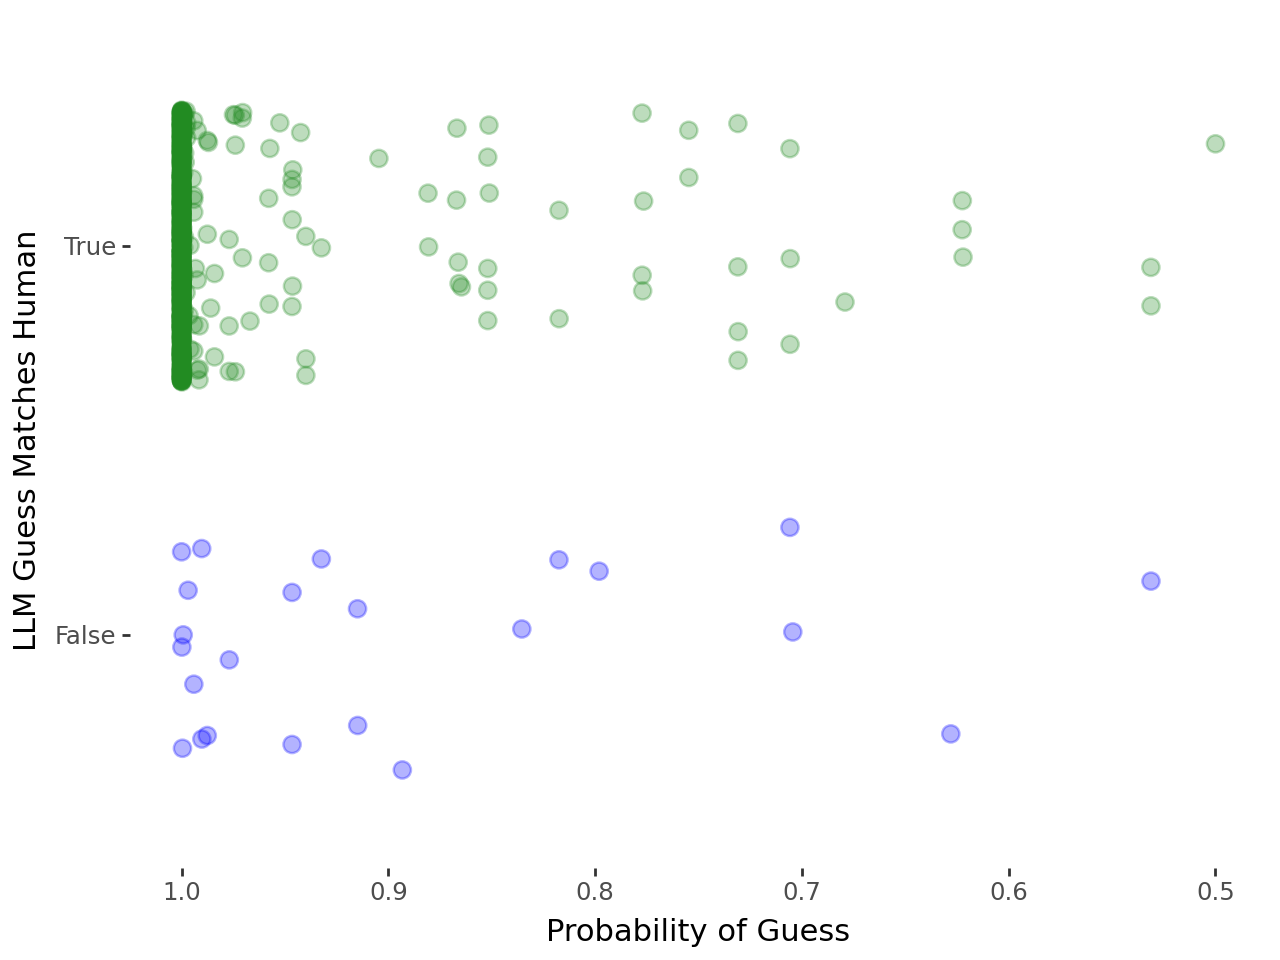

In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path
import great_tables as gt
from plotnine import *
np.random.seed(123)

# Human predictions
human_pred_csv = Path("./Data/cause_of_death.csv")
cod_df = pd.read_csv(human_pred_csv)
hm_df = cod_df[cod_df["train_test"] == "test"][[
    "cause_of_death", "category_human"]]

# AI predictions with logprobs
llm_pred_csv = "output_openai_gpt_4o_logprobs"
output_csv_path = Path("./Data/output_gpt_4o_base_0.csv")
lp_df = pd.read_csv(output_csv_path)
cols_keep = ["cause_of_death", "category", "confidence"]
lp_df = lp_df.loc[:, cols_keep]

# Compare
rec = pd.merge(hm_df, lp_df, on="cause_of_death")
rec["match"] = rec["category_human"] == rec["category"]

# Plot
(ggplot(rec, aes(y="confidence", x="match", color="match")) +
    geom_jitter(width=0.35, alpha=0.3, size = 3) +
    coord_flip() +
    scale_y_reverse() +
    xlab("LLM Guess Matches Human") +
    ylab("Probability of Guess") +
    scale_color_manual(values={True: "forestgreen", False: "blue"}) +
    theme_bw() +
    theme(
        legend_position="none",
        axis_line=element_blank(),      # removes axis lines (flip-safe)
        panel_border=element_blank(),   # removes plot outline
        panel_grid=element_blank()
)
)

For the majority of the answers returned, the LLM was supremely confident (over 99.5%). Most of these high confidence results were also ones that agreed with our human. When the LLM was not supremely confident, the chance of matching our human was much lower. We can use this as a way to target which LLM results we might want to manually review. In the table below we cut the data into two groups based on confidence. For the high confidence group, the accuracy is >99%. For the less confident group, accuracy is down to 82%, but only represents ~10% of the dataset. In practice, we could focus any human attention on this subset, allowing a nice balance between accuracy and expediency.  

In [ ]:
rec["confidence_band"] = pd.cut(rec["confidence"], bins=[0, 0.995, 1.0])

accuracy_df = rec.groupby("confidence_band", observed=False)[
    "match"].aggregate(["count", "sum", "mean"])

accuracy_gt = gt.GT(accuracy_df.reset_index())
accuracy_gt = accuracy_gt.fmt_percent(["mean"], decimals=1)

(accuracy_gt.cols_label(
    {
        "confidence_band": "Confidence",
        "count": "Attempts",
        "sum": "Matches",
        "mean": "Accuracy"
    }
)
)

Confidence,Attempts,Matches,Accuracy
"(0.0, 0.995]",101,83,82.2%
"(0.995, 1.0]",899,894,99.4%


If you are particularly observant you may have noticed that all guesses had a probability >50%. But events with <50% probability happen all the time, so how can this be? We turned the temperature of the LLM down to zero, forcing the LLM to only give the most likely token each time. This suits our task, as we are not looking for the LLM to get creative with its classification. This differs from a typical chat response you may have had from an LLM, where more randomness is built in to get richer results.

## Biasing 

*"nonenonenonenonenonenonenonenonenonenonenonenonenonenone"* 
- gpt-4o, with bias

As described previously, the most common decision was between "none" and a single other category. We can bias the model to select "none" more or less often than it did under the base conditions. 

OpenAI allow the user to re-weight the probability of any given token(s) being selected, with their logit bias feature. In our case, we can isolate the "none" token and increase or decrease it's likelihood. For those causes of death where confidence was lower, this can be enough to change the classifcation chosen by the LLM.

The results are shown in the table below. We see that a negative bias makes the model select "none" less often, manifesting in more "positives". This leads to a higher recall, but comes at the penalty of lower precision. Conversely, a positive bias has the exact opposite effect. Both modifications lead to a poorer overall performance, as denoted by the F1 score decreasing.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import great_tables as gt

# Human predictions
human_pred_csv = Path("./Data/cause_of_death.csv")
cod_df = pd.read_csv(human_pred_csv)
hm_df = cod_df[cod_df["train_test"] == "test"][[
    "cause_of_death", "category_human"]]


rec = hm_df

biases = [5, 1, 0, -1, -5]
for bias in biases:
    bias_suffix = str(bias).replace("-", "neg")
    filename = f"output_gpt_4o_base_{bias_suffix}.csv"
    output_csv_path = Path(f"./Data/{filename}")
    cols_keep = ["cause_of_death", "category"]
    lp_df = pd.read_csv(output_csv_path).loc[:, cols_keep]
    rec = pd.merge(rec, lp_df, on="cause_of_death")
    rec[bias] =  rec["category"].case_when(
        caselist= [
            (lambda x: (rec["category_human"] == x) & (x == "none"), "TN"),
            (lambda x: (rec["category_human"] == x) & (x != "none"), "TP"),
            (lambda x: (rec["category_human"] != x) & (x == "none"), "FN"),
            (lambda x: (rec["category_human"] != x) & (x != "none"), "FP")
            ]
    )
    rec = rec.drop("category", axis=1)
    

sdf = (rec[biases]
 .melt()
 .value_counts()
 .reset_index()
 .set_index("variable")
 .pivot(columns="value", values="count")
 .apply(lambda x: x.fillna(0))
)

sdf = sdf.assign(
    precision = sdf["TP"] / (sdf["TP"] + sdf["FP"]),
    recall = sdf["TP"] / (sdf["TP"] + sdf["FN"])
)
sdf = sdf.assign(
    f1 = 2 * sdf["precision"] * sdf["recall"] / (sdf["precision"] + sdf["recall"])
)

from great_tables import GT, style, loc, nanoplot_options

nnplt = nanoplot_options(
                data_point_radius=20,
                data_bar_fill_color="forestgreen",
                show_vertical_guides=False
            )

# 1. Initialize the table
tab = (
    GT(sdf.reset_index())
    
    # 2. Group columns under 'Count' and 'Scores' (Spanners)
    .tab_spanner(label="Count", columns=["TN", "FN", "TP", "FP"])
    .tab_spanner(label="Scores", columns=["precision", "recall", "f1"])
    .cols_label(
        variable="Bias",
        TN="True Negative", FN="False Negative",
        TP="True Positive", FP="False Positive",
        precision="Precision", recall="Recall", f1="F1"
    )
    .fmt_percent(columns=["precision", "recall", "f1"], decimals=0)
    .fmt_number(columns=["TN", "FN", "TP", "FP"], decimals=0)
    .fmt_nanoplot(columns="precision", plot_type="bar", autoscale=False, options=nnplt, expand_y=True)
    .fmt_nanoplot(columns="recall", plot_type="bar", autoscale=False, options=nnplt)
    .fmt_nanoplot(columns="f1", plot_type="bar", autoscale=False, options=nnplt)
    

    .cols_align(align="center", columns=["TN", "FN", "TP", "FP", "precision", "recall", "f1"])
)

tab

GT(_tbl_data=value  variable    FN     FP     TN    TP  precision    recall        f1
0            -5   1.0  269.0  664.0  66.0   0.197015  0.985075  0.328358
1            -1  15.0   21.0  912.0  52.0   0.712329  0.776119  0.742857
2             0  17.0    6.0  927.0  50.0   0.892857  0.746269  0.813008
3             1  30.0    2.0  931.0  37.0   0.948718  0.552239  0.698113
4             5  62.0    0.0  933.0   5.0   1.000000  0.074627  0.138889, _body=<great_tables._gt_data.Body object at 0x000002166A9CF860>, _boxhead=Boxhead([ColInfo(var='variable', type=<ColInfoTypeEnum.default: 1>, column_label='Bias', column_align='right', column_width=None), ColInfo(var='TN', type=<ColInfoTypeEnum.default: 1>, column_label='True Negative', column_align='center', column_width=None), ColInfo(var='FN', type=<ColInfoTypeEnum.default: 1>, column_label='False Negative', column_align='center', column_width=None), ColInfo(var='TP', type=<ColInfoTypeEnum.default: 1>, column_label='True Positive', column_align='center', column_width=None), ColInfo(var='FP', type=<ColInfoTypeEnum.default: 1>, column_label='False Positive', column_align='center', column_width=None), ColInfo(var='precision', type=<ColInfoTypeEnum.default: 1>, column_label='Precision', column_align='center', column_width=None), ColInfo(var='recall', type=<ColInfoTypeEnum.default: 1>, column_label='Recall', column_align='center', column_width=None), ColInfo(var='f1', type=<ColInfoTypeEnum.default: 1>, column_label='F1', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000021664FCEED0>, _spanners=Spanners([SpannerInfo(spanner_id='Count', spanner_level=0, spanner_label='Count', spanner_units=None, spanner_pattern=None, vars=['TN', 'FN', 'TP', 'FP'], built=None), SpannerInfo(spanner_id='Scores', spanner_level=0, spanner_label='Scores', spanner_units=None, spanner_pattern=None, vars=['precision', 'recall', 'f1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x000002166AFC8080>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x000002166AFCA5D0>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002166AFC9A60>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002166AFCBE90>, <great_tables._gt_data.FormatInfo object at 0x000002166AFC8050>, <great_tables._gt_data.FormatInfo object at 0x000002166AFCBBF0>, <great_tables._gt_data.FormatInfo object at 0x000002166AFCBF80>, <great_tables._gt_data.FormatInfo object at 0x000002166AFCAF90>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, catego

The logit bias can take any value between -100 and +100. We found that small adjustments led to a sensible nudging. Larger adjustments were problematic to the overall task. When we turned the bias down to -100, which essentially bans the word "none", the model started to inject "None" or "NONE" instead. We were truly outplayed. When we turned the bias up to +100 the model came back with the quote shown above... it was talking complete "none" sense.

Although the logit bias worked in our case, it is also possible to nudge a model's tendecies via your prompt as well. We already did this to get certain diseases classed as "none", such as genetic. The logit bias doesn't allow for context, which could lead to problems where different options share overlapping tokens. We found this feature fun, but perhaps less useful than the other techiques explored.  

## Fine-tuning 

*"Practice makes perfect"* 
- Anonymous

Another approach we applied was fine-tuning. Instead of nudging the model’s behaviour at run time, fine-tuning teaches the model directly using human-annotated labels. In another words, biasing changes behaviour, while fine-tuning changes understanding.

We fine-tuned the smaller gpt-4o-mini model. It is around 16–17 times cheaper and noticeably faster than gpt-4o, while already performing well out of the box. This makes it a compelling option for efficient, real-world production use. Each training example consisted of a cause-of-death description, a short instruction, and a single label (either one smoking-related category or "none"). No explanations. No extra text.

We used 2,579 records for training and held out 1,000 for testing. From the training set, 20% was reserved for validation. The natural class imbalance was left unchanged, with around 93% of records labelled "none". One important lesson from the fine-tuning process was that formatting consistency matters. Training prompts and inference prompts, including their structure and chunk size, must be consistent. When they were not, the model occasionally returned malformed outputs. Once we standardised on a single prompt template, the results became much more reliable.

The results are shown in the table below. Fine-tuning reduced false positives, improved recall, and pushed precision up to 96%. Despite its smaller size, the fine-tuned model came surprisingly close to the performance of gpt-4o, at a fraction of the cost.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import great_tables as gt

# Human predictions
human_pred_csv = Path("./Data/cause_of_death.csv")
cod_df = pd.read_csv(human_pred_csv)
hm_df = cod_df[cod_df["train_test"] == "test"][[
    "cause_of_death", "category_human"]]


rec = hm_df

suffixes = ["mini_base", "base_0", "mini_ft"]
for suffix in suffixes:
    filename = f"output_gpt_4o_{suffix}.csv"
    output_csv_path = Path(f"./Data/{filename}")
    cols_keep = ["cause_of_death", "category"]
    lp_df = pd.read_csv(output_csv_path).loc[:, cols_keep]
    rec = pd.merge(rec, lp_df, on="cause_of_death")
    rec[suffix] =  rec["category"].case_when(
        caselist= [
            (lambda x: (rec["category_human"] == x) & (x == "none"), "TN"),
            (lambda x: (rec["category_human"] == x) & (x != "none"), "TP"),
            (lambda x: (rec["category_human"] != x) & (x == "none"), "FN"),
            (lambda x: (rec["category_human"] != x) & (x != "none"), "FP")
            ]
    )
    rec = rec.drop("category", axis=1)
    

sdf = (rec[suffixes]
 .melt()
 .value_counts()
 .reset_index()
 .set_index("variable")
 .pivot(columns="value", values="count")
 .apply(lambda x: x.fillna(0))
)

sdf = sdf.assign(
    precision = sdf["TP"] / (sdf["TP"] + sdf["FP"]),
    recall = sdf["TP"] / (sdf["TP"] + sdf["FN"])
)
sdf = sdf.assign(
    f1 = 2 * sdf["precision"] * sdf["recall"] / (sdf["precision"] + sdf["recall"])
)

from great_tables import GT, style, loc, nanoplot_options

nnplt = nanoplot_options(
                data_point_radius=20,
                data_bar_fill_color="forestgreen",
                show_vertical_guides=False
            )

# 1. Initialize the table
tab = (
    GT(sdf.reset_index())
    
    # 2. Group columns under 'Count' and 'Scores' (Spanners)
    .tab_spanner(label="Count", columns=["TN", "FN", "TP", "FP"])
    .tab_spanner(label="Scores", columns=["precision", "recall", "f1"])
    .cols_label(
        variable="Model",
        TN="True Negative", FN="False Negative",
        TP="True Positive", FP="False Positive",
        precision="Precision", recall="Recall", f1="F1"
    )
    .fmt_percent(columns=["precision", "recall", "f1"], decimals=0)
    .fmt_number(columns=["TN", "FN", "TP", "FP"], decimals=0)
    .fmt_nanoplot(columns="precision", plot_type="bar", autoscale=False, options=nnplt, expand_y=True)
    .fmt_nanoplot(columns="recall", plot_type="bar", autoscale=False, options=nnplt)
    .fmt_nanoplot(columns="f1", plot_type="bar", autoscale=False, options=nnplt)

    .cols_align(align="center", columns=["TN", "FN", "TP", "FP", "precision", "recall", "f1"])
)

tab

GT(_tbl_data=value   variable  FN  FP   TN  TP  precision    recall        f1
0         base_0  17   6  927  50   0.892857  0.746269  0.813008
1      mini_base  31   8  925  36   0.818182  0.537313  0.648649
2        mini_ft  23   2  931  44   0.956522  0.656716  0.778761, _body=<great_tables._gt_data.Body object at 0x0000011324235D00>, _boxhead=Boxhead([ColInfo(var='variable', type=<ColInfoTypeEnum.default: 1>, column_label='Model', column_align='left', column_width=None), ColInfo(var='TN', type=<ColInfoTypeEnum.default: 1>, column_label='True Negative', column_align='center', column_width=None), ColInfo(var='FN', type=<ColInfoTypeEnum.default: 1>, column_label='False Negative', column_align='center', column_width=None), ColInfo(var='TP', type=<ColInfoTypeEnum.default: 1>, column_label='True Positive', column_align='center', column_width=None), ColInfo(var='FP', type=<ColInfoTypeEnum.default: 1>, column_label='False Positive', column_align='center', column_width=None), ColInfo(var='precision', type=<ColInfoTypeEnum.default: 1>, column_label='Precision', column_align='center', column_width=None), ColInfo(var='recall', type=<ColInfoTypeEnum.default: 1>, column_label='Recall', column_align='center', column_width=None), ColInfo(var='f1', type=<ColInfoTypeEnum.default: 1>, column_label='F1', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000011321E2AF00>, _spanners=Spanners([SpannerInfo(spanner_id='Count', spanner_level=0, spanner_label='Count', spanner_units=None, spanner_pattern=None, vars=['TN', 'FN', 'TP', 'FP'], built=None), SpannerInfo(spanner_id='Scores', spanner_level=0, spanner_label='Scores', spanner_units=None, spanner_pattern=None, vars=['precision', 'recall', 'f1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000011325FC06B0>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000011325FC0890>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000011325FC0B90>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000011325FC0EF0>, <great_tables._gt_data.FormatInfo object at 0x0000011325FC0B60>, <great_tables._gt_data.FormatInfo object at 0x0000011325FC1D00>, <great_tables._gt_data.FormatInfo object at 0x0000011325FC1FD0>, <great_tables._gt_data.FormatInfo object at 0x0000011325FC20F0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scs

Mean prediction confidence also rose steadily as we moved from the base models to the fine-tuned one, reaching 0.996 after fine-tuning (compared with 0.988 for base gpt-4o and 0.993 for base gpt-4o-mini). This suggests that fine-tuning produces a model that is not only more accurate, but also more confident in its decisions.

## Conclusion

This case study shows that LLMs can meaningfully automate messy actuarial classification tasks that are difficult to solve with traditional rules.

A few clear takeaways are:

- Base models already handle nuanced medical text well
- Confidence scores help identify where human review adds the most value
- Logit bias can steer outputs, but comes with trade-offs
- Fine-tuning allows smaller models to punch well above their weight

LLMs are not a replacement for actuarial judgement. If they are used well, they help actuaries handle large volumes of routine work and freeing them to focus on interpretation, validation, and decision-making.

The real opportunity is not just to automate existing processes, but to rethink how actuarial data pipelines are built in the first place.